<a href="https://colab.research.google.com/github/moamenkhalaf97/code/blob/main/malaria%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

In [8]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteD0GT1H/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [9]:
for data in dataset[0].take(1):
  print(data)



(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [10]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [11]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )


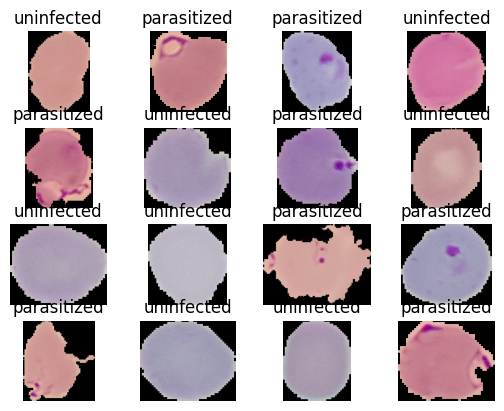

In [12]:
for i,(image,label) in enumerate(train_dataset.take(16)):
   ax=plt.subplot(4,4,i+1)
   plt.imshow(image)
   plt.title(dataset_info.features['label'].int2str(label))
   plt.axis('off')


In [13]:
IM_SIZE=224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE)),label


In [14]:
print(train_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [15]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [16]:
for image,data in train_dataset.take(1):
  print(image,label)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [17]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
lenet_model=tf.keras.Sequential([
                InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
                Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
                BatchNormalization(),
                MaxPool2D(pool_size=2,strides=2),
                Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu'),
                BatchNormalization(),
                MaxPool2D(pool_size=2,strides=2),

                Flatten(),
                Dense(100,activation="relu"),
                BatchNormalization(),
                Dense(10,activation="relu"),
                BatchNormalization(),
                Dense(1,activation="sigmoid"),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                        

In [19]:
y_true=[0,1,0,0]
y_pred=[0.6,0.51,0.94,1]
bce=tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [20]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
             metrics='accuracy'
             )


In [21]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 57s 73ms/step - loss: 0.3028 - accuracy: 0.8739 - val_loss: 0.2191 - val_accuracy: 0.9270
Epoch 2/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1873 - accuracy: 0.9385 - val_loss: 0.1827 - val_accuracy: 0.9437
Epoch 3/20
689/689 [==============================] - 45s 66ms/step - loss: 0.1780 - accuracy: 0.9384 - val_loss: 0.1971 - val_accuracy: 0.9332
Epoch 4/20
689/689 [==============================] - 45s 65ms/step - loss: 0.1486 - accuracy: 0.9498 - val_loss: 0.1833 - val_accuracy: 0.9510
Epoch 5/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1358 - accuracy: 0.9533 - val_loss: 0.1439 - val_accuracy: 0.9546
Epoch 6/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1132 - accuracy: 0.9609 - val_loss: 0.4015 - val_accuracy: 0.9111
Epoch 7/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1166 - accuracy: 0.9600 - val_loss: 0.2800 - val_accuracy:

In [22]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

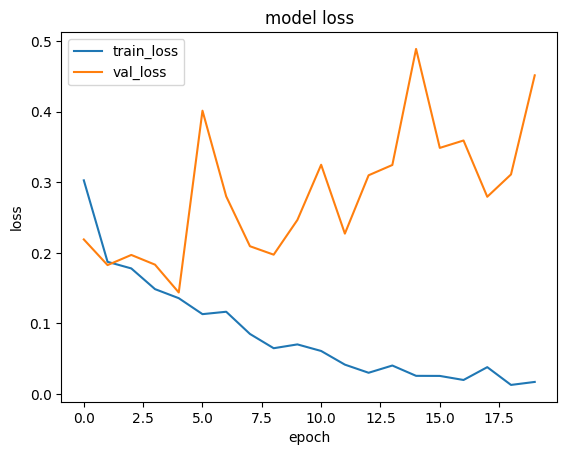

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

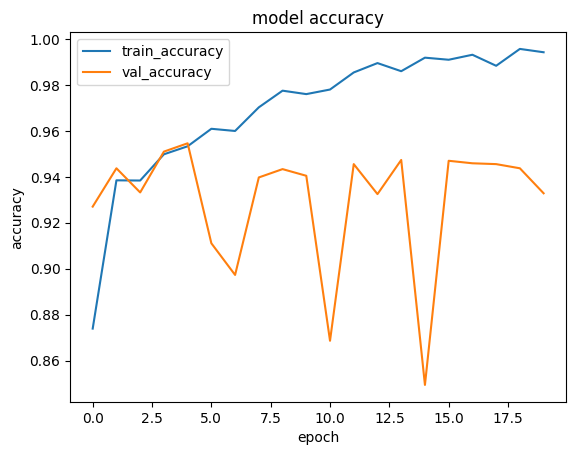

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [26]:
#model evaluation and test
test_dataset=test_dataset.batch(1)

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 3ms/step - loss: 0.4926 - accuracy: 0.9343


[0.49256065487861633, 0.9343489408493042]

In [31]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else :
    return str('U')

In [32]:
#model prediction
value=lenet_model.predict(test_dataset.take(1))[0][0]
print(parasite_or_not(value))

1/1 [==============================] - 13s 13s/step
P


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


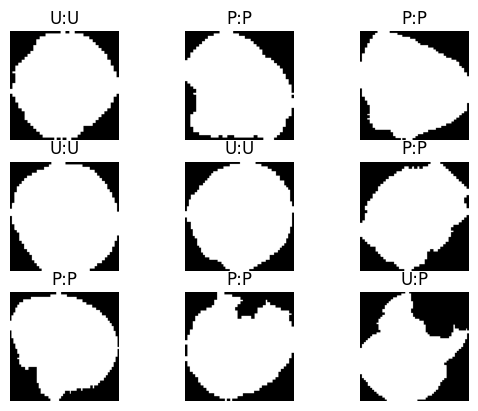

In [35]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')